# Explore Generative Adversarial Network (GAN)
## Objective
Use GAN approach on an image/its trimap to generate a good alpha matte/image cutout.
* Train a generator to generate the alpha matte/image cutout
* Train a discriminator to distinguish the ground truth alpha matte/image cutout from the alpha matte/image cutout created by the generator

## Sources:
* [Simple GAN - GitHub code](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/1.%20SimpleGAN/fc_gan.py)
* [Google courses on GAN](https://developers.google.com/machine-learning/gan)

## What is GAN?
GAN = generative model; creates new data instances similar to the training data.

## How?
GAN pairs 2 neural network models together:
* a generator: learns to generate the target output
* a discriminator: a classifier that learns to distinguish the real data from the output created the generator.

"The generator tries to fool the discriminator, and the discriminator tries to keep from being fooled."
The discriminator penalizes the generator when it performs badly: the backpropagation allows to update the weights of the generator.

"Backpropagation adjusts each weight in the right direction by calculating the weight's impact on the output — how the output would change if you changed the weight."

## GAN applications
[Examples of different applications](https://developers.google.com/machine-learning/gan/applications)



## Traditional GAN diagram
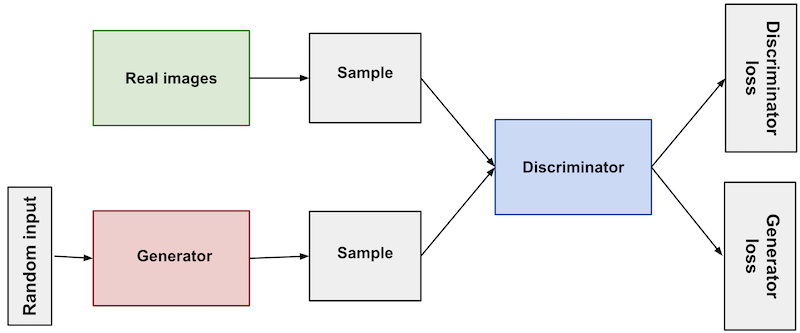

## Adapted GAN diagram
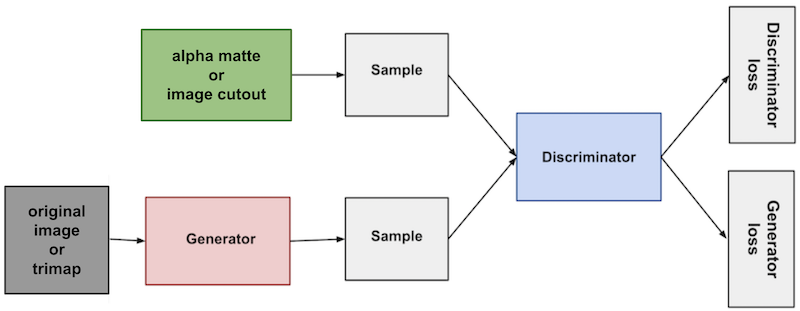

## Training
### For generator

#### input
- random input such as random noise (from experiments, noise distibution is not important => choose easy distribution like a uniform distribution).
- or non-random input --> to shape the output

#### During generator training
Discriminator not training during generator training.

1. Sample random noise.
2. Generate output from sampled random noise.
3. "Real" or "Fake" classification by discriminator
4. Compute generator loss from discriminator classification.
5. Backpropagate through both the discriminator and generator to obtain gradients.
6. Use gradients to change only the generator weights.

### For discriminator
#### Training data
- Real data: positive examples (1)
- fake data created by the generator: negative (0)


#### During discriminator training
Generator creates outputs to train but it's not training (= weights not updated).

1. discriminator classifies real and generator's outputs
2. discriminator loss penalizes discrimator if misclassification => its weights are updated through backpropagation.

### Alternate training
Iteratively:
1. Discriminator trains for 1 or more epochs to better classify real or fake data, but not the generator.
2. Then, generator trains: for 1 or more epochs, but not the discriminator "otherwise the generator would be trying to hit a moving target and might never converge."

As the generator keeps getting better, the discrimator needs to recognize the generator's flaws.

### Convergence
Potential problem: as the generator produces better results, it gets harder for the discriminator to distinguish real data from the fake.

If the generator creates a perfect copy, the discriminator performance drops to 50% accuracy: it's like "flipping a coin to make a prediction".

=> "This progression poses a problem for convergence of the GAN as a whole: the discriminator feedback gets less meaningful over time. If the GAN continues training past the point when the discriminator is giving completely random feedback, then the generator starts to train on junk feedback, and its own quality may collapse."

"For a GAN, convergence is often a fleeting, rather than stable, state."

## Loss functions
GANs try to replicate a probability distribution => loss functions should represents the distance between the distribution of the generator fake data and the distribution of the real data.

### commons loss functions
- minimax loss (minimize `log(1 - D(G(z)))`) or modified minimax loss (maximize `log(D(G(z)))`)
  - D(x) = discriminator's estimate of probability that real data instance x is real
  - G(z) = generator's output when given noise z
  - D(G(z)) = discriminator's estimate of the probability that a fake instance is real

- Wasserstein loss:
  - Critic Loss: `D(x) - D(G(z))`; discriminator tries to maximize this function: to maximize the difference between its output on real instances and its output on fake instances.

  - Generator Loss: D(G(z)); generator tries to maximize the discriminator's output for its fake instances.

      - D(x) = critic's output for a real instance.
      - G(z) = generator's output when given noise z.
      - D(G(z)) = critic's output for a fake instance.

      - Requirements: "weights throughout the GAN be clipped so that they remain within a constrained range."

      - Benefits: "Wasserstein GANs less vulnerable to getting stuck than minimax-based GANs, and avoid problems with vanishing gradients. The earth mover distance also has the advantage of being a true metric: a measure of distance in a space of probability distributions. Cross-entropy is not a metric in this sense."


## Common problems
### Vanishing Gradients
= discriminator too good that the generator can't make progress.

=> Possible solutions:
- Wasserstein loss
- Modified minimax loss

### Mode collapse
= generator always produces the same output(s) to effectively fool the discriminator (when generator over-optimized for that discriminator).

=> Possible solutions:
- Wasserstein loss: as this function allows to avoid vanishing gradients, the discriminator learns to reject the same outputs that the generator keeps creating. => generator will have to produce a new output.
- Unrolled GANs: to prevent generator from over-optimizing for a single discriminator, unrolled GANs uses a generator loss function containing the classifications of
  - the current discriminator
  - and future discriminator versions

### No convergence
Frequent failures to converge

=> Possible solutions:
- Add noise to discriminator inputs
- Penalize discriminator weights

# Install dependencies

# Import

# Upload data & mount drive

# Buid code

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)


# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1



Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch [0/50] Batch 0/1875                       Loss D: 0.6590, loss G: 0.6983
Epoch [1/50] Batch 0/1875                       Loss D: 0.2866, loss G: 1.5317
Epoch [2/50] Batch 0/1875                       Loss D: 0.5398, loss G: 0.9899
Epoch [3/50] Batch 0/1875                       Loss D: 0.6203, loss G: 1.0577
Epoch [4/50] Batch 0/1875                       Loss D: 0.7526, loss G: 0.6587
Epoch [5/50] Batch 0/1875                       Loss D: 0.3302, loss G: 1.4806
Epoch [6/50] Batch 0/1875                       Loss D: 0.9228, loss G: 0.5778
Epoch [7/50] Batch 0/1875                       Loss D: 0.6086, loss G: 0.8518
Epoch [8/50] Batch 0/1875                       Loss D: 0.5971, loss G: 1.1331
Epoch [9/50] Batch 0/1875                       Loss D: 0.5762, loss G: 1.2835
Epoch [10/50] Batch 0/1875                       Loss D: 0.4458, loss G: 1.4675
Epoch [11/50] Batch 0/1875                       Loss D: 0.5878, loss G: 1.2718
Epoch [12/50] Batch 0/1875                       L